# Tutorial 1: Simulating the spreading of forest fires using cellular automata

## Introduction to Forest Fires

For this tutorial, we will be modeling forest fires. Annually, forest fires consume 4 to 5 million acres of land in the United States rending this land and anything else in the fire’s path barren and charred. By attempting to model forest fires, we hope to be able to greater understand the factors that contribute to the spreading of forest fires in order to help people make more educated decisions about stopping them and inform preventative policy measures that can be enacted to curtail these fires.

## Introduction to Cellular Automata

Cellular automata models are a type of model where each cell represents a discrete unit. In our case, each unit will be one cell of a forest and is one of 4 states: empty, unburned vegetation, burning vegetation, or extinguished. Cells that border those on fire naturally have a higher likelihood of igniting in the next time steps. In the beginning we will implement a very basic cellular automata, where the likelihood of catching fire is only determined by whether or not the cells adjacent to it are on fire. This model will change as we add more and more components to our function that includes other characteristics of a forest such as wind speed, elevation, and type of tree.

## Code

First lets import what we need, and also define some state variables that represent possible initial states for each cell in our forest!

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib as mpl
import matplotlib.pyplot as plt

empty = 0
unburned = 1
burning = 2 
burned = 3

Then, lets write a few methods that allow us to get the basic parts of the simulation up and running:

* `create_world(n, d)`: Returns a new grid world, where each index will hold a numerical value indicating what is in that cell. The new world will have size `(n+2)` by `(n+2)` due to the one cell padding added on all four size for simpler matrix computations. These boundary cells will all be initialized to be "empty". The probability that any given cell will have vegetation that can catch fire is expressed through `d`.

* `show_world(W)`: Displays the world in a colorful way! Each different possible state a cell can be in is expressed as a different color. The different states are: "Empty" (0), "Unburned" (1), "Burning" (2), "Burned" (3)

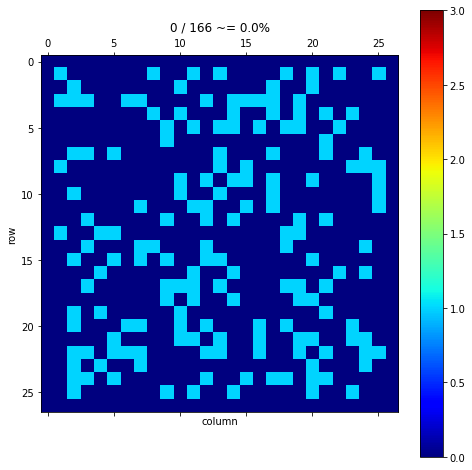

In [2]:
def create_world(n, q):
    world = np.zeros((n+2, n+2))
    forest = world[1:-1, 1:-1]
    forest[:, :] = np.random.choice([0, 1], p=[1-q, q], size=(n, n))
    return world

def show_world(W, title=None, **args):
    if 'cmap' not in args:
        args['cmap'] = 'jet'
    if 'vmin' not in args and 'vmax' not in args:
        args['vmin'] = 0
        args['vmax'] = 3
    plt.figure(figsize=(8, 8))
    plt.matshow(W, fignum=1, **args)
    plt.xlabel('column')
    plt.ylabel('row')
    plt.colorbar()
    if title is None:
        num_trees = (W > 0).sum()
        if num_trees > 0:
            num_burnt = (W == 3).sum()
            percent = num_burnt / num_trees * 1e2
            title = '{} / {} ~= {:.1f}%'.format(num_burnt, num_trees, percent)
        else:
            title = ''
    plt.title(title)
    pass

# Demo:
# Uncomment this next line for a 3x3 fully covered unburned world
# World = create_world(3, 1)
World = create_world(25, 0.25)
show_world(World)

Now let's define some helper functions that are going to help us in our journey to model a forest fire!

Note that all functions following the `is_<something>` functions will return a matrix of equal size to the given world in variable `W`!

In [3]:
def is_empty(W):
    return W == empty

# This tells us if something was vegetation at any point, burned or unburned!
def is_vegetation(W):
    return W > empty

def is_unburned(W):
    return W == 1

def is_burning(W):
    return W == 2

def is_burned(W):
    return W == 3

def count(W, cond_fun):
    return cond_fun(W).sum()

def summarize_world(W):
    def suffix(n):
        return (1, "tree") if n == 1 else (n, "trees")
    m, n = W.shape[0]-2, W.shape[1]-2
    n_trees = count(W, is_vegetation)
    n_unburned = count(W, is_unburned)
    n_burning = count(W, is_burning)
    n_burned = count(W, is_burned)
    
    print("The world has dimensions: {} x {}".format(m, n))
    print("There are {} cell(s) that have had vegetation in them".format(n_trees))
    print("There are {} cell(s) of vegetation that are unburned".format(n_unburned))
    print("There are {} cell(s) of vegetation on fire".format(n_burning))
    print("There are {} cell(s) of vegetation completely burned".format(n_burned))

summarize_world(World)

The world has dimensions: 25 x 25
There are 166 cell(s) that have had vegetation in them
There are 166 cell(s) of vegetation that are unburned
There are 0 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


Now we're going to need a way to start our fire! Normally these massive fires start with one or a few spots catching on fire because of human error. To simulate that, let's pick one of the Unburned locations at random and start a fire there!

We'll call our function `start_fire(W)`, and it'll do exactly that. Transition one of our unburned locations to on fire!

The comments also show a way of setting specific cells on fire, if you wanted to start a fire in the same places every time!

The world has dimensions: 25 x 25
There are 166 cell(s) that have had vegetation in them
There are 165 cell(s) of vegetation that are unburned
There are 1 cell(s) of vegetation on fire
There are 0 cell(s) of vegetation completely burned


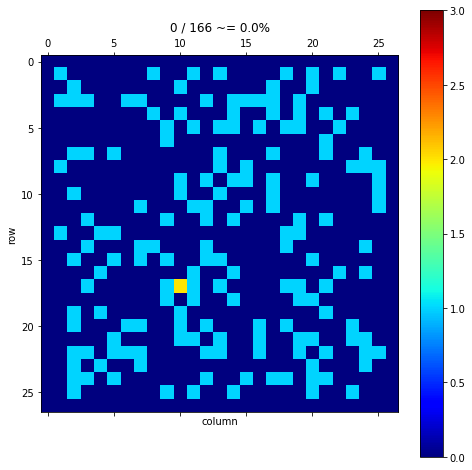

In [4]:
def start_fire(W, cells=None):
    
    W_new = W.copy()
    
    if cells == None:
        F = W[1:-1, 1:-1]
        W_new = W.copy()
        F_new = W_new[1:-1, 1:-1]
        I, J = np.where(is_unburned(F)) # Positions of all trees
        if len(I) > 0:
            k = np.random.choice(range(len(I))) # Index of tree to ignite
            i, j = I[k], J[k]
            assert F_new[i, j] == 1, "Attempting to ignite a non-tree?"
            F_new[i, j] += 1
    else:
        W_new = W.copy()
        
        for x,y in cells:
            W_new[x,y] = 2
    
    return W_new

# Start a fire somewhere random in the world! 
World_next = start_fire(World)
# Uncomment this following line if you want to set custom locations on fire!
# World_next = start_fire(World, [(2,2), (2,3), (3,2)])
show_world(World_next)
summarize_world(World_next)

## Deterministic Spread Fire

Now that we've successfully started a fire, lets spread it. Here we will implement a function called `spread_fire(W)` that will simulate one time step. How the fire actually spreads in real life will be more complicated then this example, but for now, let's just make it so that whenever the neighbors are on fire, that cell will definitely catch fire! Lets not forget about the tiles that are already on fire, they need to be put out!

Don't worry, we'll implement more complex cases later on.

This function works by taking the locations of all trees (in `Vegetation`) and then checking if any of the 8 cells bordering that tree are on fire. Since this basic model is doing deterministic transitions, if any of the bordering cells are on fire then the center cell will also light on fire.

The world has dimensions: 25 x 25
There are 166 cell(s) that have had vegetation in them
There are 160 cell(s) of vegetation that are unburned
There are 5 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


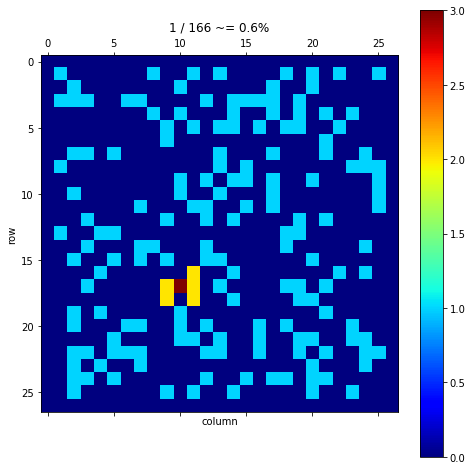

In [5]:
def spread_fire(W):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    # Spread fire to neighbors
    W_new[1:-1, 1:-1] += Vegetation[1:-1, 1:-1] \
                         & (
                              Fires[:-2, :-2]  | Fires[1:-1, :-2] | Fires[2:, :-2]
                            | Fires[:-2, 1:-1] |                    Fires[2:, 1:-1]
                            | Fires[:-2, 2:]   | Fires[1:-1, 2:]  | Fires[2:, 2:]
                           )
    
    # Extinguish current fires
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]
    return W_new

# Spread one time-step of fire. Then show and summarize the world!
World_next = spread_fire(World_next)
show_world(World_next)
summarize_world(World_next)

Only doing one timestep is no fun, let's do another!

The world has dimensions: 25 x 25
There are 166 cell(s) that have had vegetation in them
There are 158 cell(s) of vegetation that are unburned
There are 2 cell(s) of vegetation on fire
There are 6 cell(s) of vegetation completely burned


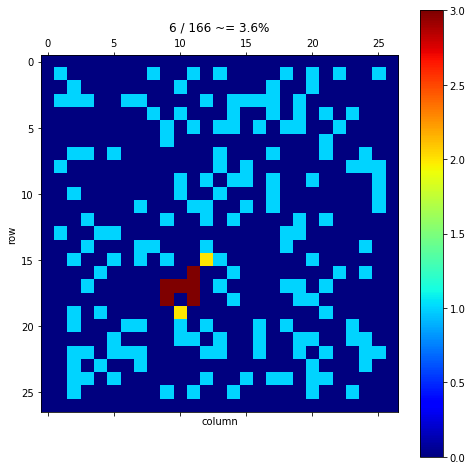

In [6]:
# Second Timestep
World_next = spread_fire(World_next)
show_world(World_next)
summarize_world(World_next)

## Probabilistic Spreading

Now you may be wondering, how would I make this model behave more like real life fires? The answer is to introduce probabilities! In real life, having a neighbor on fire isn't going to guarantee catching fire! Lets develop a system that can take this probability of catching on fire into account!

This function models the probability that a cell catches on fire as below, where we are considering the probability that cell $x$ is on fire and the probability of fire is $p_f$, and there are $n$ surrounding neighbors on fire.

$$P(x) = 1 - (1 - p_f)^n$$

In [7]:
def spread_fire_p(W, fire_spread_prob=0.4):
    W_new = W.copy()
    Vegetation = is_unburned(W)
    Fires = is_burning(W)
    
    # Spread fire to neighbors
    # First count how many neighbor of a cell are on fire!
    num_neighbors_on_fire = (Fires[:-2, :-2].astype(int) + Fires[1:-1, :-2] + Fires[2:, :-2] 
                             + Fires[:-2, 1:-1]                             + Fires[2:, 1:-1] 
                             + Fires[:-2, 2:]            + Fires[1:-1, 2:]  + Fires[2:, 2:])
    
    # If there's no vegetation at a certain spot, we don't want to calculate anything related to it's neighbors,
    # so lets set those locations to zero
    num_neighbors_on_fire = np.multiply(num_neighbors_on_fire, Vegetation[1:-1, 1:-1].astype(int))
    
    # Now calcualte the chance of each location doesn't catch fire at the next time-step.
    # All probabilities start out as 1.0 - fire_spread_prob
    fire_prob_matrix = np.ones(num_neighbors_on_fire.shape) - fire_spread_prob
    
    # Because each neighbor independently influences a cell, the total probability of not spreading is equal to
    # the (probabilty of one neighbor not spreading) ^ (number of neighbors). Taking 1.0 - that value transforms the
    # calculated probability to represent the: probability of the cell catching on fire due to any of the neighbors.
    fire_prob_matrix = 1.0 - np.power(fire_prob_matrix, num_neighbors_on_fire)
    
    # Again we don't care about a specific cell's value if there's no vegetation there, so we zero out
    # the locations that don't have vegetation there!
    fire_prob_matrix = np.multiply(fire_prob_matrix, Vegetation[1:-1, 1:-1].astype(int))
    
    # Now to use our probabiltiy matrix we've generated, we need to generate a matrix of all random 
    # values between 0.0 and 1.0, and compare if the random generated value is less than the probability of catching fire!
    randys = np.random.rand(*fire_prob_matrix.shape)
    new_on_fires = randys < fire_prob_matrix
    
    # Now we "add" one to each location that used to be "unburned" that now will be "burning" since the value for
    # "unburned" is (1) and the value for "burning" is (2), this works out to transition our states perfectly!
    W_new[1:-1, 1:-1] += new_on_fires
 
    # We still want to extinguish current fires after one time-step, so let's go do that
    W_new[1:-1, 1:-1] += Fires[1:-1, 1:-1]

    # Aaaaand we're done!
    return W_new



To demonstrate this probabilistic fire spreading, we'll generate a world entirely of vegetation to see how fires do not spread in a uniform circle around the start.

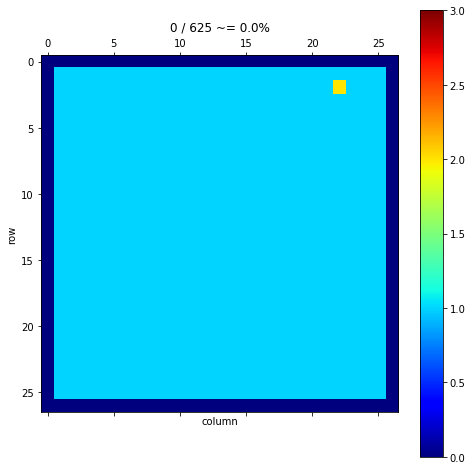

In [8]:
world_2 = create_world(25, 1)
world_2 = start_fire(world_2)

show_world(world_2)

The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 620 cell(s) of vegetation that are unburned
There are 4 cell(s) of vegetation on fire
There are 1 cell(s) of vegetation completely burned


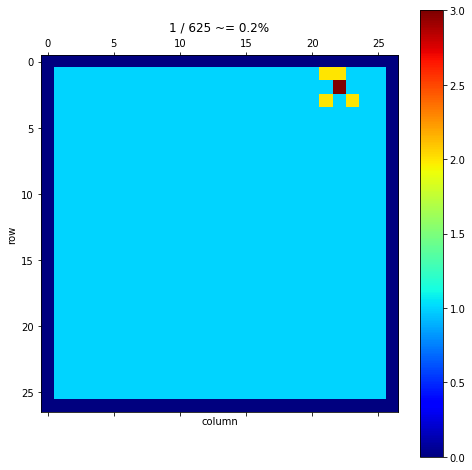

In [9]:
world_2 = spread_fire_p(world_2, fire_spread_prob=.5)
show_world(world_2)
summarize_world(world_2)

The world has dimensions: 25 x 25
There are 625 cell(s) that have had vegetation in them
There are 614 cell(s) of vegetation that are unburned
There are 6 cell(s) of vegetation on fire
There are 5 cell(s) of vegetation completely burned


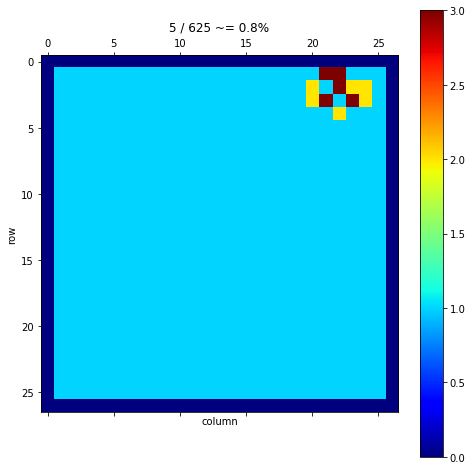

In [10]:
# One more time step

world_2 = spread_fire_p(world_2, fire_spread_prob=.5)
show_world(world_2)
summarize_world(world_2)

## Full Simulation

Now that we've figured out how to do two timesteps of our simulation, let's try and do a full run and see how our fires spread!

We're going to write a function called `simulate(W0, t_max=None, inplace=False)` that by default runs until the world reaches a steady-state configuration!

If `inplace` is set to `False`, then the simulator will also return all the timesteps!

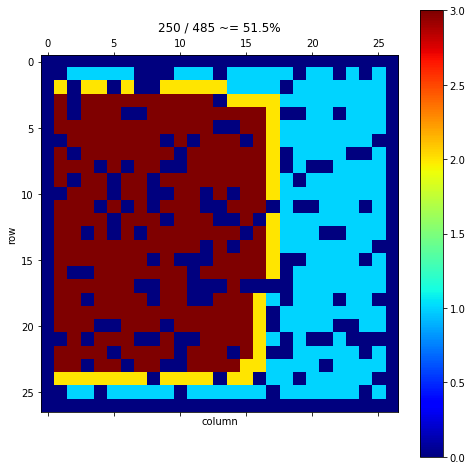

At time 11 (max=22)...
The world has dimensions: 25 x 25
There are 485 cell(s) that have had vegetation in them
There are 190 cell(s) of vegetation that are unburned
There are 45 cell(s) of vegetation on fire
There are 250 cell(s) of vegetation completely burned


In [11]:
def simulate(W0, t_max=None, inplace=False, spread_prob=None):
    if t_max is None:
        n_max = max(W0.shape)
        t_max = n_max * ((2*n_max-1) // 2)
    W = np.zeros((W0.shape[0], W0.shape[1], 2 if inplace else t_max+1))
    t_cur = 0
    W[:, :, t_cur] = W0
    for t in range(t_max):
        t_next = (t_cur+1)%2 if inplace else t+1
        
        if spread_prob:
            W[:, :, t_next] = spread_fire_p(W[:, :, t_cur], fire_spread_prob=spread_prob)
        else:
            W[:, :, t_next] = spread_fire(W[:, :, t_cur])
            
        if (W[:, :, t_cur] == W[:, :, t_next]).all():
            t_cur = t_next
            break
        t_cur = t_next
    return (W[:, :, t_cur], t) if inplace else W[:, :, :t_cur+1]
    
def viz(W, t=0):
    show_world(W[:, :, t])
    plt.show()
    print("At time {} (max={})...".format(t, W.shape[2]-1))
    summarize_world(W[:, :, t])
    
def run_simulation(n, q, **args):
    return simulate(start_fire(create_world(n, q)), **args)

W = run_simulation(25, 0.75)
viz(W, W.shape[2] // 2)

Now you may be wondering, "I thought setting `inplace` to `False` returned all of the timesteps, not just one of them" and you would be right! Here's a funky little widget that lets you look at every timestep.

In [12]:
from ipywidgets import interact

def iviz(t=0):
    viz(W, t);
    
W = run_simulation(25, 0.5)
interact(iviz, t=(0, W.shape[2]-1))

interactive(children=(IntSlider(value=0, description='t', max=44), Output()), _dom_classes=('widget-interact',…

<function __main__.iviz(t=0)>

We can also simulate our probabilistic model as below.

In [13]:
W = run_simulation(25, 1, spread_prob=.5)
interact(iviz, t=(0, W.shape[2]-1))

interactive(children=(IntSlider(value=0, description='t', max=23), Output()), _dom_classes=('widget-interact',…

<function __main__.iviz(t=0)>

## Monte Carlo Runs

Cool! So we can now simulate a full run-through of a randomly generated forest fire, what if we want to see how one of our parameters changes the outcome? Think back to the beginning, and remember that when we generate a world, we can give it a probability that determines how likely a cell is to contain burnable Vegetation! Let's simulate what would happen if we made that probability higher, or in other words, make our world more dense! 

First though, let's write the method `simulate_many(n, q, trials)` that lets us simulate many different iterations with probability `q`

In [14]:
def simulate_many(n, q, trials):
    percent_burned = np.zeros(trials)
    time_to_burn = np.zeros(trials)
    for trial in range(trials):
        W_last, t_last = run_simulation(n, q, inplace=True)
        n_trees = count(W_last, is_vegetation)
        n_burnt = count(W_last, is_burned)
        percent_burned[trial] = n_burnt / n_trees if n_trees > 0 else 0.0
        time_to_burn[trial] = t_last
    return percent_burned, time_to_burn

percentages, times_to_burn = simulate_many(25, 0.25, 100)
avg_percentage, std_percentage = percentages.mean(), percentages.std()
avg_time, std_time = times_to_burn.mean(), times_to_burn.std()
print("Percentage of vegetation that burned: ~ {:.1f}% +/- {:.1f}%".format(1e2*avg_percentage,
                                                                      1e2*std_percentage))
print("Time to burn: ~ {} +/- {:.1f} timesteps".format(avg_time, std_time))

Percentage of vegetation that burned: ~ 5.2% +/- 5.2%
Time to burn: ~ 4.35 +/- 3.0 timesteps


With that method out of the way, now let's simulate world with many different density probability values! Specifically, let's do 5% increments starting from 5% and working our way up to 100%! Oh and also let's make a pretty graph.

In [15]:
n_many = 25
Q = np.linspace(0, 1, 21)[1:]
Percentages = np.zeros((len(Q), 2))
Times = np.zeros((len(Q), 2))
for k, q in enumerate(Q):
    print("Simulating vegetation density q={}...".format(q))
    percentages, times = simulate_many(n_many, q, 100)
    Percentages[k, :] = [percentages.mean(), percentages.std()]
    Times[k, :] = [times.mean(), times.std()]

Simulating vegetation density q=0.05...
Simulating vegetation density q=0.1...
Simulating vegetation density q=0.15000000000000002...
Simulating vegetation density q=0.2...
Simulating vegetation density q=0.25...
Simulating vegetation density q=0.30000000000000004...
Simulating vegetation density q=0.35000000000000003...
Simulating vegetation density q=0.4...
Simulating vegetation density q=0.45...
Simulating vegetation density q=0.5...
Simulating vegetation density q=0.55...
Simulating vegetation density q=0.6000000000000001...
Simulating vegetation density q=0.65...
Simulating vegetation density q=0.7000000000000001...
Simulating vegetation density q=0.75...
Simulating vegetation density q=0.8...
Simulating vegetation density q=0.8500000000000001...
Simulating vegetation density q=0.9...
Simulating vegetation density q=0.9500000000000001...
Simulating vegetation density q=1.0...


This plot is for the fraction of trees that burned given a certain vegetation density probability.

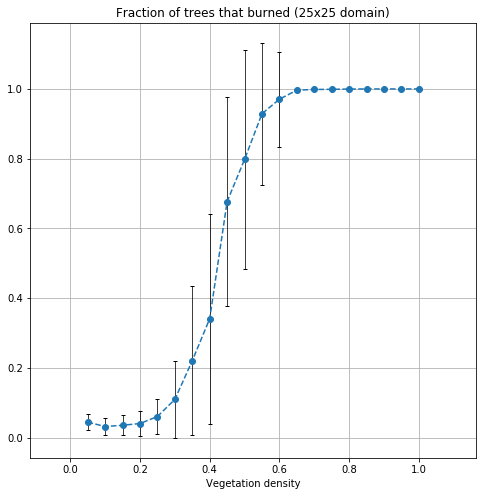

In [16]:
plt.figure(figsize=(8, 8))
plt.errorbar(Q, Percentages[:, 0], yerr=Percentages[:, 1], fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Vegetation density');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.grid()

This second graph will be for time needed to reach the steady-state configuration! In other words, how quickly does our fire either go out/eradicate the entire forest.

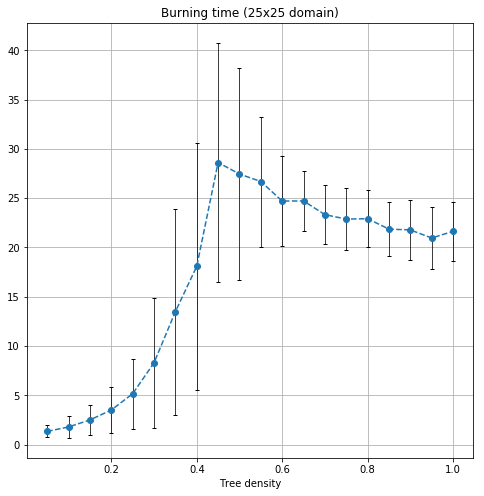

In [17]:
plt.figure(figsize=(8, 8))
Z = 1 # Q*n_many*n_many # Normalizing factor
plt.errorbar(Q, Times[:, 0]/Z, yerr=Times[:, 1]/Z,
             fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
#plt.gca().axis('equal')
plt.xlabel('Tree density');
plt.title('Burning time ({}x{} domain)'.format(n_many, n_many));
plt.grid()

We can also examine how different spread probabilities effect the fraction of trees burned.

In [18]:
def simulate_many_p(n, q, trials, spread_prob):
    percent_burned = np.zeros(trials)
    time_to_burn = np.zeros(trials)
    for trial in range(trials):
        W_last, t_last = run_simulation(n, q, inplace=True, spread_prob=spread_prob)
        n_trees = count(W_last, is_vegetation)
        n_burnt = count(W_last, is_burned)
        percent_burned[trial] = n_burnt / n_trees if n_trees > 0 else 0.0
        time_to_burn[trial] = t_last
    return percent_burned, time_to_burn

percentages, times_to_burn = simulate_many_p(25, 0.25, 100, .5)
avg_percentage, std_percentage = percentages.mean(), percentages.std()
avg_time, std_time = times_to_burn.mean(), times_to_burn.std()
print("Percentage of vegetation that burned: ~ {:.1f}% +/- {:.1f}%".format(1e2*avg_percentage,
                                                                      1e2*std_percentage))
print("Time to burn: ~ {} +/- {:.1f} timesteps".format(avg_time, std_time))

Percentage of vegetation that burned: ~ 2.0% +/- 1.8%
Time to burn: ~ 2.44 +/- 1.8 timesteps


Here, we'll examine the effect of fire spreading probabilities from 0.5 to 1 for a map of density 1, meaning that it is full of trees.

In [19]:
P = np.linspace(0, 1, 21)[1:]
Percentages_2 = np.zeros((len(P), 2))
Times_2 = np.zeros((len(P), 2))
for k, p in enumerate(P):
    print("Simulating fire spread prob p={}...".format(p))
    percentages, times = simulate_many_p(25, 1, 100, p)
    Percentages_2[k, :] = [percentages.mean(), percentages.std()]
    Times_2[k, :] = [times.mean(), times.std()]

Simulating fire spread prob p=0.05...
Simulating fire spread prob p=0.1...
Simulating fire spread prob p=0.15000000000000002...
Simulating fire spread prob p=0.2...
Simulating fire spread prob p=0.25...
Simulating fire spread prob p=0.30000000000000004...
Simulating fire spread prob p=0.35000000000000003...
Simulating fire spread prob p=0.4...
Simulating fire spread prob p=0.45...
Simulating fire spread prob p=0.5...
Simulating fire spread prob p=0.55...
Simulating fire spread prob p=0.6000000000000001...
Simulating fire spread prob p=0.65...
Simulating fire spread prob p=0.7000000000000001...
Simulating fire spread prob p=0.75...
Simulating fire spread prob p=0.8...
Simulating fire spread prob p=0.8500000000000001...
Simulating fire spread prob p=0.9...
Simulating fire spread prob p=0.9500000000000001...
Simulating fire spread prob p=1.0...


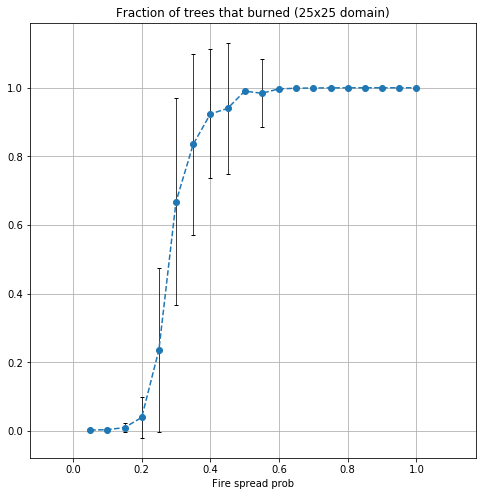

In [20]:
plt.figure(figsize=(8, 8))
plt.errorbar(P, Percentages_2[:, 0], yerr=Percentages_2[:, 1], fmt='o--', ecolor='black', elinewidth=0.75, capsize=2);
plt.gca().axis('equal')
plt.xlabel('Fire spread prob');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.grid()

We can run more simulations to see how the combination of vegetation density and fire spread effect the fire's tree consumption

In [21]:
n_many = 25

Q = np.linspace(0, 1, 21)[1:]
P = np.linspace(0, 1, 21)[1:]
Percentages_3 = np.zeros((len(Q), len(P), 2))
Times_3 = np.zeros((len(Q), len(P), 2))

for k_1, q in enumerate(Q):
    for k_2, p in enumerate(P):
        print("Simulating p={}, q={}...".format(p, q))
        percentages, times = simulate_many_p(n_many, q, 100, p)
        Percentages_3[k_1, k_2, :] = [percentages.mean(), percentages.std()]
        Times_3[k_1, k_2, :] = [times.mean(), times.std()]
        
        

Simulating p=0.05, q=0.05...
Simulating p=0.1, q=0.05...
Simulating p=0.15000000000000002, q=0.05...
Simulating p=0.2, q=0.05...
Simulating p=0.25, q=0.05...
Simulating p=0.30000000000000004, q=0.05...
Simulating p=0.35000000000000003, q=0.05...
Simulating p=0.4, q=0.05...
Simulating p=0.45, q=0.05...
Simulating p=0.5, q=0.05...
Simulating p=0.55, q=0.05...
Simulating p=0.6000000000000001, q=0.05...
Simulating p=0.65, q=0.05...
Simulating p=0.7000000000000001, q=0.05...
Simulating p=0.75, q=0.05...
Simulating p=0.8, q=0.05...
Simulating p=0.8500000000000001, q=0.05...
Simulating p=0.9, q=0.05...
Simulating p=0.9500000000000001, q=0.05...
Simulating p=1.0, q=0.05...
Simulating p=0.05, q=0.1...
Simulating p=0.1, q=0.1...
Simulating p=0.15000000000000002, q=0.1...
Simulating p=0.2, q=0.1...
Simulating p=0.25, q=0.1...
Simulating p=0.30000000000000004, q=0.1...
Simulating p=0.35000000000000003, q=0.1...
Simulating p=0.4, q=0.1...
Simulating p=0.45, q=0.1...
Simulating p=0.5, q=0.1...
Simul

Simulating p=1.0, q=0.55...
Simulating p=0.05, q=0.6000000000000001...
Simulating p=0.1, q=0.6000000000000001...
Simulating p=0.15000000000000002, q=0.6000000000000001...
Simulating p=0.2, q=0.6000000000000001...
Simulating p=0.25, q=0.6000000000000001...
Simulating p=0.30000000000000004, q=0.6000000000000001...
Simulating p=0.35000000000000003, q=0.6000000000000001...
Simulating p=0.4, q=0.6000000000000001...
Simulating p=0.45, q=0.6000000000000001...
Simulating p=0.5, q=0.6000000000000001...
Simulating p=0.55, q=0.6000000000000001...
Simulating p=0.6000000000000001, q=0.6000000000000001...
Simulating p=0.65, q=0.6000000000000001...
Simulating p=0.7000000000000001, q=0.6000000000000001...
Simulating p=0.75, q=0.6000000000000001...
Simulating p=0.8, q=0.6000000000000001...
Simulating p=0.8500000000000001, q=0.6000000000000001...
Simulating p=0.9, q=0.6000000000000001...
Simulating p=0.9500000000000001, q=0.6000000000000001...
Simulating p=1.0, q=0.6000000000000001...
Simulating p=0.05,

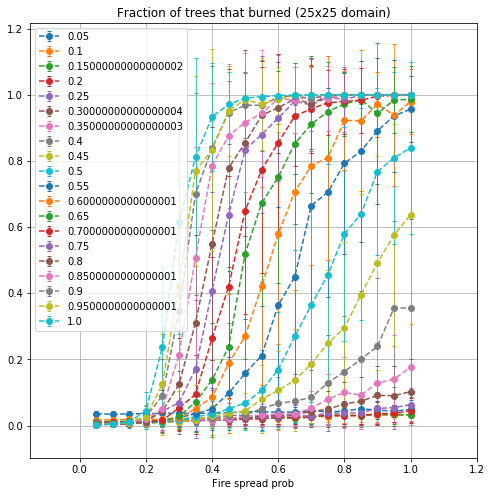

In [22]:
plt.figure(figsize=(8, 8))
for i in range(Percentages_3.shape[0]):
    plt.errorbar(P, Percentages_3[i, :, 0], yerr=Percentages_3[i, :, 1], fmt='o--', elinewidth=0.75, capsize=2);

plt.gca().axis('equal')
plt.xlabel('Fire spread prob');
plt.title('Fraction of trees that burned ({}x{} domain)'.format(n_many, n_many));
plt.legend(Q, loc='upper left')
plt.grid()

Although this graph is very crowded, we can see how the vegetation density and fire spread probability interplay. Higher values of both lead to more higher amounts of burning.